# Inference Attack with AutoML and MNIST Digits-- Trial \#1
ISU CEADS Lab under Dr. Leslie Kerby <br>
Samantha Ross <br><br>

This is a notebook detailing an inference attack (or "model stealing") against a target with a sequential architecture. The attack uses AutoML (AutoKeras) and the MNIST Digits data set.

## TensorFlow Versioning
TensorFlow has now updated to v2.12. This notebook was originally created using TensorFlow v2.11.

# Imports

In [ ]:
# Installs and Imports
!pip install autokeras

import autokeras as ak
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.5/337.5 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

# Dataset Preparation 
Loading in, preprocessing, and creating a train-test-split of the MNIST Digits data

In [ ]:
# Loading Data
# MNIST digits dataset (70,000 images of hand-written numbers, each 28x28 pixels) 
# Default split = 60k in training, 10k in testing

mnist_digits = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist_digits.load_data()

print(X_train_full.shape)
print(X_test.shape)
print(y_train_full.shape)
print(y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [ ]:
# Preprocess the data as necessary

# Scale to [0,1]
X_train_full = X_train_full/255
X_test = X_test/255

#Reshape to 1D, or flatten, before sending to keras
X_train_full = X_train_full.reshape(-1, 784) # -1 (auto): full size
X_test = X_test.reshape(-1, 784)

# The training set should have 60k images and the test set 10k, and be 784 (28*28)
print(X_train_full.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [ ]:
# Splitting Data

# Create a validation set within the training set 
#   -- using 10% of the training data.
from sklearn.model_selection import train_test_split
X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_full, 
                                                                y_train_full, 
                                                                test_size=1/10)
# Check 
print(X_train_tr.shape)
print(X_train_v.shape)
print(y_train_tr.shape)
print(y_train_v.shape)

(54000, 784)
(6000, 784)
(54000,)
(6000,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(10000, 784)
(10000,)


# Victim Model
Sequential Model

In [ ]:
# Architecture
# 3 hidden layers with 800 neurons and relu activation
seq_model = keras.models.Sequential()
seq_model.add(keras.layers.Dense(800, activation="relu", input_shape=(784,), 
                             name="First_Hidden_Layer"))
seq_model.add(keras.layers.Dense(800, activation="relu", 
                             name="Second_Hidden_Layer"))
seq_model.add(keras.layers.Dense(800, activation="relu", 
                             name="Third_Hidden_Layer"))
seq_model.add(keras.layers.Dense(10, activation="softmax", name="Output_Layer"))

# Compile Model
seq_model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
seq_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_Hidden_Layer (Dense)  (None, 800)               628000    
                                                                 
 Second_Hidden_Layer (Dense)  (None, 800)              640800    
                                                                 
 Third_Hidden_Layer (Dense)  (None, 800)               640800    
                                                                 
 Output_Layer (Dense)        (None, 10)                8010      
                                                                 
Total params: 1,917,610
Trainable params: 1,917,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Victim Model
keras.utils.plot_model(seq_model, show_shapes=True)

In [ ]:
# Train for 20 epochs w/ early stopping
history_seq_model = seq_model.fit(X_train_tr, y_train_tr, epochs=20, batch_size=32,
                    validation_data=(X_train_v, y_train_v),
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/20
1688/1688 [==============================] - 8s 3ms/step - loss: 0.5785 - accuracy: 0.8525 - val_loss: 0.2809 - val_accuracy: 0.9197
Epoch 2/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2490 - accuracy: 0.9285 - val_loss: 0.2197 - val_accuracy: 0.9368
Epoch 3/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1934 - accuracy: 0.9446 - val_loss: 0.1753 - val_accuracy: 0.9513
Epoch 4/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.1585 - accuracy: 0.9548 - val_loss: 0.1490 - val_accuracy: 0.9585
Epoch 5/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.1324 - accuracy: 0.9626 - val_loss: 0.1282 - val_accuracy: 0.9653
Epoch 6/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.1137 - accuracy: 0.9679 - val_loss: 0.1237 - val_accuracy: 0.9623
Epoch 7/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0986 - accuracy: 0.9720 - val_loss: 0.1062 - val_accuracy:

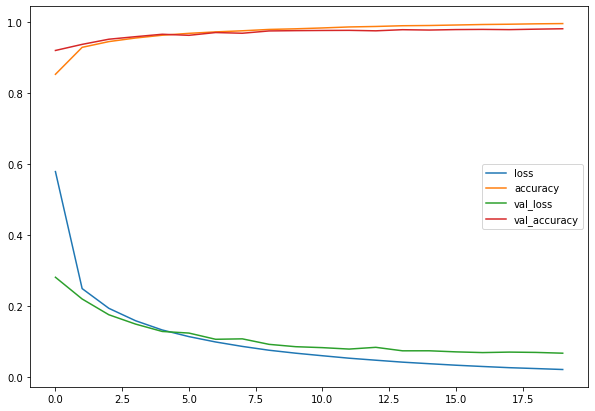

In [ ]:
# Graph
pd.DataFrame(history_seq_model.history).plot(figsize=(10,7)) 

In [ ]:
# Accuracies of test set and validation set (to assess overfit)
print("Test. Acc: ", seq_model.evaluate(X_test, y_test)) # test set
print("Valid. Acc.: ", seq_model.evaluate(X_train_v, y_train_v)) # validation set

313/313 [==============================] - 1s 2ms/step - loss: 0.0676 - accuracy: 0.9777
Test. Acc:  [0.06755174696445465, 0.9776999950408936]
188/188 [==============================] - 0s 2ms/step - loss: 0.0670 - accuracy: 0.9808
Valid. Acc.:  [0.06700301915407181, 0.9808333516120911]


## Predictions

In [ ]:
predictions = np.argmax(seq_model.predict(X_test), axis=-1)
predictions

313/313 [==============================] - 1s 2ms/step


array([7, 2, 1, ..., 4, 5, 6])

## Misclassified Images and Confusion Matrix

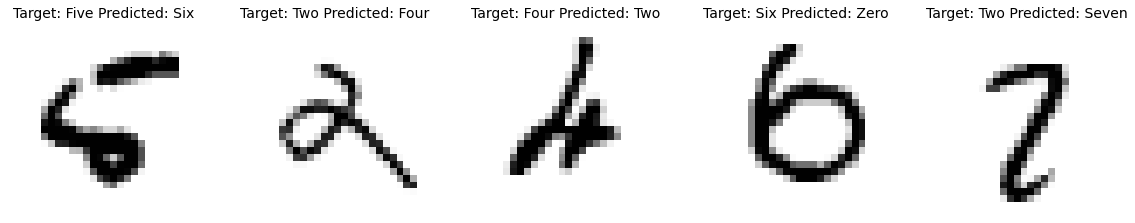

In [ ]:
# Display misclassified images for this experimental model
classes = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 
           'Six', 'Seven', 'Eight', 'Nine']

misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test, predictions):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(20,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  plt.imshow(X_test[misclassifiedIndexes[index]].reshape(28,28), cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {classes[y_test[misclassifiedIndexes[index]]]} Predicted: {classes[predictions[misclassifiedIndexes[index]]]}', fontsize=14)

plt.show()

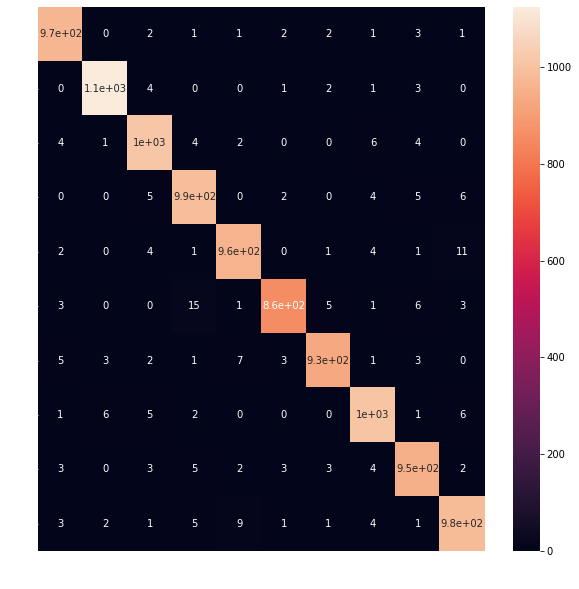

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True class', color='white')
plt.xlabel('Predicted class', color='white')
plt.tick_params(color='white',labelcolor='white')
plt.show()

# Model Stealing
Reverse engineering the target model by generating an attack model with AutoKeras

In [ ]:
# Use a subset of dataset images (X_test) and the victim model's predictions 
# on that data (predictions)

X_train_tr2, X_test2, y_train_tr2, y_test2 = train_test_split(X_test, predictions,
                                                                test_size=3/10)
print(X_test.shape)
print(y_test2.shape)

print()
print(X_train_tr2.shape)
print(X_test2.shape)
print(y_train_tr2.shape)
print(y_test2.shape)

(10000, 784)
(3000,)

(7000, 784)
(3000, 784)
(7000,)
(3000,)


In [ ]:
# AutoKeras needs at least 3 channels (n, x, x), so add another channel
X_train_tr2 = X_train_tr2.reshape(-1, 28, 28)
print(X_train_tr2.shape)
X_test2 = X_test2.reshape(-1, 28, 28)
print(X_test2.shape)

(7000, 28, 28)
(3000, 28, 28)


In [ ]:
from autokeras.utils.types import LossType
# initialize AK image classifier that will try 2 models (for time)
auto_model = ak.ImageClassifier(max_trials=2, loss = 'sparse_categorical_crossentropy') # specifying loss

# AK defaults to binary_crossentropy or categorical_crossentropy depending on # of classes
# Changing (specifying) sparse_categorical for victim-->attack prediction data compatability

In [ ]:
# Search for the best model
am_history = auto_model.fit(X_train_tr2, y_train_tr2, 20,
                 callbacks=[keras.callbacks.EarlyStopping(patience=2)]) # Decreased patience from 5 to 2 (for time)

Trial 2 Complete [00h 08m 18s]
val_loss: 1.0375417470932007

Best val_loss So Far: 0.12658986449241638
Total elapsed time: 00h 08m 33s
Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.4100 - accuracy: 0.8726
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1423 - accuracy: 0.9590
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1097 - accuracy: 0.9659
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0886 - accuracy: 0.9699
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0742 - accuracy: 0.9747
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0603 - accuracy: 0.9791
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0562 - accuracy: 0.9809
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0551 - accuracy: 0.9793
Epoch 9/20
219/219 [==============================] - 1s 4ms/step

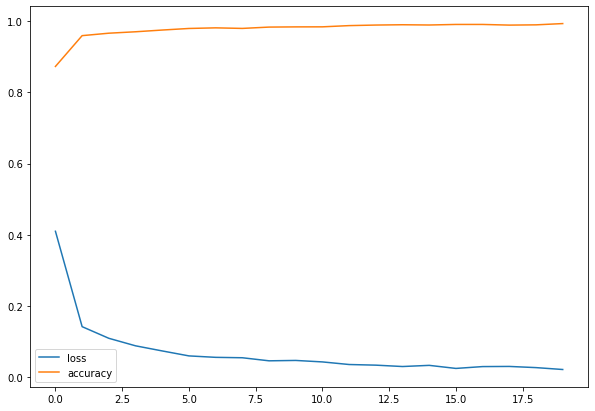

In [ ]:
pd.DataFrame(am_history.history).plot(figsize=(10,7)) 

In [ ]:
# Evaluate
auto_model.evaluate(X_test2, y_test2)

94/94 [==============================] - 1s 7ms/step - loss: 0.1609 - accuracy: 0.9693


[0.16090428829193115, 0.9693333506584167]

## Predictions
Having the attack model make predictions using its own test data

In [ ]:
predictions = auto_model.predict(X_test2)
predictions

94/94 [==============================] - 0s 2ms/step


array([['4'],
       ['2'],
       ['9'],
       ...,
       ['0'],
       ['4'],
       ['1']], dtype='<U1')

In [ ]:
# Fix predictions format #1
attack_pred = np.concatenate(predictions3)
print(attack_pred)

['4' '2' '9' ... '0' '4' '1']


In [ ]:
# Fix predictions format #2
attack_pred2 = attack_pred.astype(np.int64)
print(attack_pred2)

[4 2 9 ... 0 4 1]


In [ ]:
attack_pred2[:10]

array([4, 2, 9, 0, 4, 8, 4, 3, 0, 7])

## Misclassified Images and Confusion Matrix

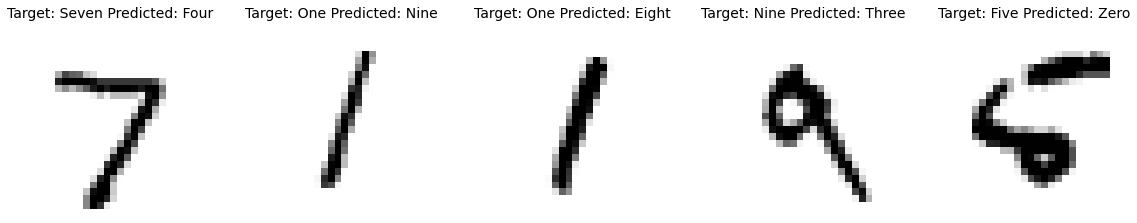

In [ ]:
# Display misclassified images for this experimental model
classes = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 
           'Six', 'Seven', 'Eight', 'Nine']
           
misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test, attack_pred2):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(20,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  plt.imshow(X_test[misclassifiedIndexes[index]].reshape(28,28), cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {classes[y_test[misclassifiedIndexes[index]]]} Predicted: {classes[attack_pred2[misclassifiedIndexes[index]]]}', fontsize=14)

plt.show()

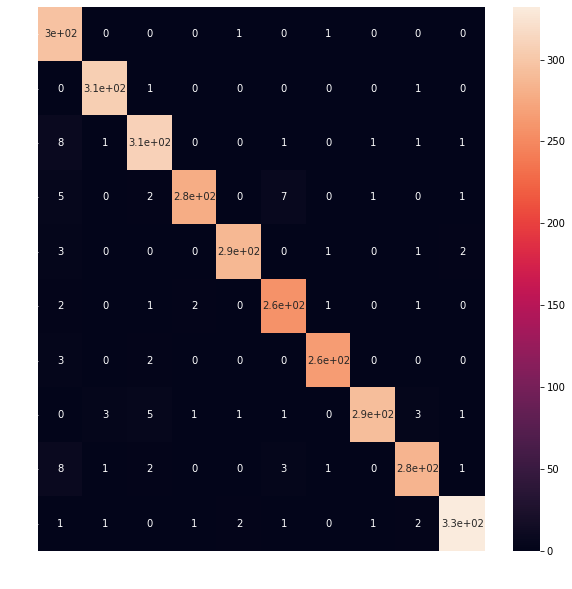

In [ ]:
# Confusion Matrix for the attack model on its on data
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm2 = confusion_matrix(y_test2, attack_pred2)
cm_df2 = pd.DataFrame(cm2, index=classes, columns=classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df2, annot=True)
plt.ylabel('True class', color='white')
plt.xlabel('Predicted class', color='white')
plt.tick_params(color='white',labelcolor='white')
plt.show()

## Export Model

In [ ]:
stolen_model = auto_model_2.export_model()
stolen_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 28, 28)           0         
 t32)                                                            
                                                                 
 expand_last_dim (ExpandLast  (None, 28, 28, 1)        0         
 Dim)                                                            
                                                                 
 normalization (Normalizatio  (None, 28, 28, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                             

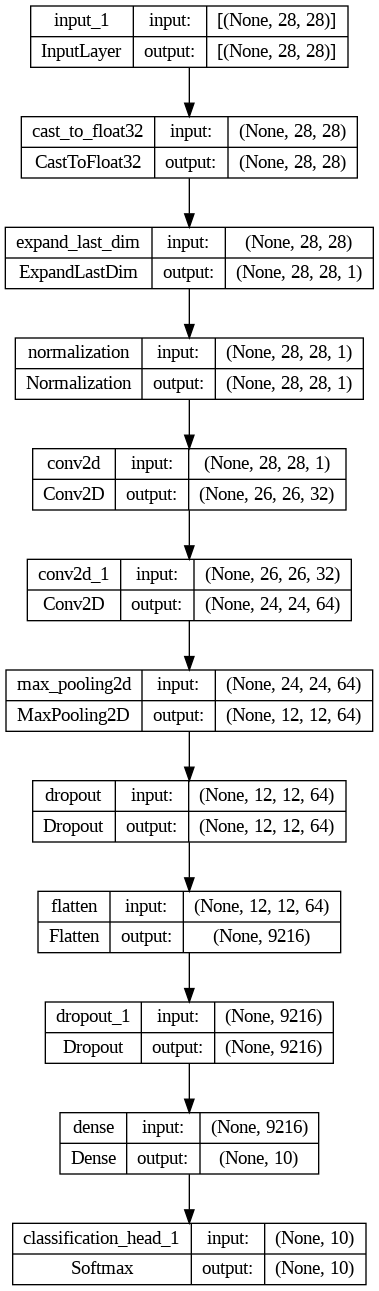

In [ ]:
# Attack model
keras.utils.plot_model(stolen_model2, show_shapes=True)

## Functional Equivalence Assessment

#### Individual Test Data 
How well did each predict their individual test data

In [ ]:
# Look at first 30 predictions and compare with actual
print(predictions[:30]) # Victim Model Predictions --> predicted X_test
print(y_test[:30]) # y test data for victim
print()
print(attack_pred2[:30]) # Attack Model Predictions --> predicted X_test2
print(y_test2[:30]) # y test data for attack


[7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]

[4 2 9 0 4 8 4 3 0 7 8 3 5 8 9 5 0 1 8 8 8 2 8 2 9 0 0 5 1 0]
[4 2 9 0 4 8 4 3 0 7 8 3 5 4 9 5 0 1 8 8 8 2 8 2 9 0 0 5 1 0]


#### Attack Model on Victim Model's Data**
How well can the attack model predict the victim model's data (X_test)<br>

In [ ]:
X_test_reshape = X_test.reshape(-1, 28, 28) # (n, x, x) needed for AK
print(X_test_reshape.shape)
print(X_test.shape)

(10000, 28, 28)
(10000, 784)


In [ ]:
attack_pred3 = np.concatenate(auto_model.predict(X_test_reshape)) # attack model predictions given same data as original model
print(attack_pred3)
print(attack_pred3[:10])

313/313 [==============================] - 1s 2ms/step
['7' '2' '1' ... '4' '5' '6']
['7' '2' '1' '0' '4' '1' '4' '9' '6' '9']


In [ ]:
# Look at first 30 predictions
print(predictions[:30]) # Victim Model Predictions
print()
print(attack_pred3[:30]) # Attack Model Predictions
print()
# Compare with actual values
print(y_test[:30]) # Victim Model test data (actual)

[7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]

[7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]


In [ ]:
# Look at next 30 predictions
print(predictions[30:60]) # Victim Model Predictions
print()
print(attack_pred3[30:60]) # Attack Model Predictions
# Compare with actual values
print(y_test[30:60]) # Victim Model test data (actual)

[3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5]

[3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5]
[3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5]


#### Victim Model on Attack Model's Data
How well does the original model predict on the data from the stolen model (data: X_test2)?

In [ ]:
# reshape X_test2 for original model
X_test2_reshape = X_test2.reshape(-1, 784)
print(X_test2_reshape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
test_pred = np.argmax(seq_model.predict(X_test2_reshape), axis=-1)
print(test_pred[:10])

94/94 [==============================] - 0s 2ms/step
[4 2 9 0 4 8 4 3 0 7]


In [ ]:
# Look at first 30 predictions
print(test_pred_V2[:30]) # Victim Model Predictions (using X_test2 instead of X_test)
print()
print(attack_pred2[:30]) # Attack Model Predictions (unchanged --> uses X_test2)
print()
print(y_test2[:30]) # y values for X_test2

[4 2 9 0 4 8 4 3 0 7 8 3 5 4 9 5 0 1 8 8 8 2 8 2 9 0 0 5 1 0]

[4 2 9 0 4 8 4 3 0 7 8 3 5 8 9 5 0 1 8 8 8 2 8 2 9 0 0 5 1 0]

[4 2 9 0 4 8 4 3 0 7 8 3 5 4 9 5 0 1 8 8 8 2 8 2 9 0 0 5 1 0]


In [ ]:
# Look at next 30 predictions (30 to 60)
print(test_pred_V2[30:60]) # Victim Model Predictions
print()
print(attack_pred2[30:60]) # Attack Model Predictions
print()
print(y_test2[30:60])

[6 0 8 5 1 0 7 9 1 8 9 4 0 8 8 5 2 9 9 5 6 1 7 4 7 5 3 8 1 9]

[6 0 8 5 1 0 3 9 1 8 9 4 0 8 9 5 2 9 9 5 6 1 7 4 7 5 3 8 2 9]

[6 0 8 5 1 0 7 9 1 8 9 4 0 8 8 5 2 9 9 5 6 1 7 4 7 5 3 8 1 9]
